In [1]:
import os
import zarr
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import UNet_2D, aug
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
)

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_4', 'denoised'), ('TS_5_4', 'denoised'), ('TS_21', 'denoised'), ('TS_3', 'denoised'), ('TS_1', 'denoised'), ('TS_73_6', 'denoised'), ('TS_7', 'denoised'), ('TS_19', 'denoised'), ('TS_5', 'denoised'), ('TS_23', 'denoised'), ('TS_12', 'denoised'), ('TS_26', 'denoised'), ('TS_8', 'denoised'), ('TS_99_9', 'denoised'), ('TS_20', 'denoised'), ('TS_6_4', 'denoised'), ('TS_69_2', 'denoised'), ('TS_17', 'denoised'), ('TS_0', 'denoised'), ('TS_16', 'denoised'), ('TS_2', 'denoised'), ('TS_10', 'denoised'), ('TS_25', 'denoised'), ('TS_24', 'denoised'), ('TS_22', 'denoised'), ('TS_6', 'denoised'), ('TS_9', 'denoised'), ('TS_15', 'denoised'), ('TS_18', 'denoised'), ('TS_13', 'denoised'), ('TS_14', 'denoised'), ('TS_11', 'denoised')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/32 [00:00<?, ?it/s]


100

In [3]:
import torch
import torchvision.transforms.functional as F
import random

Valid-Epoch: 0, Loss: 0.1231193131281306:  92%|█████████▏| 184/200 [00:08<00:00, 22.15it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 0, VALID_SCORE: 0.04784906940072753


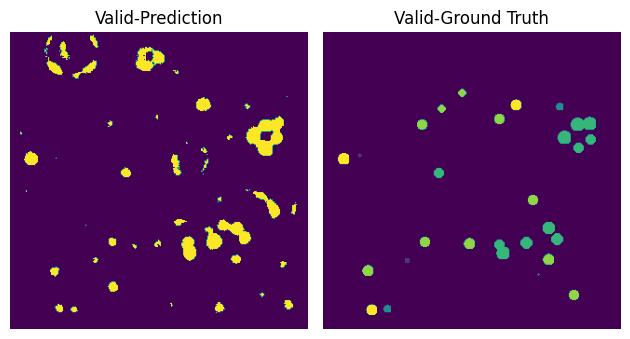

Valid-Epoch: 1, Loss: 0.1017066604791857:  92%|█████████▏| 184/200 [00:08<00:00, 22.20it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 1, VALID_SCORE: 0.05011121400378976


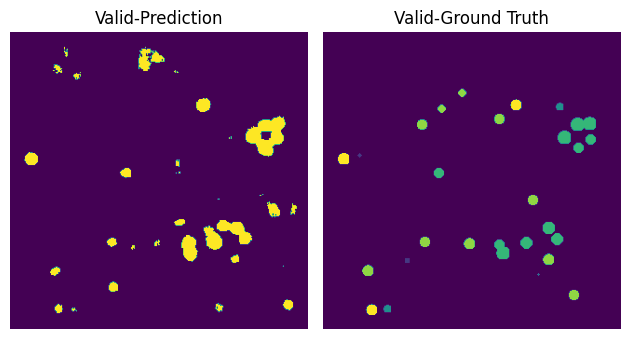

Valid-Epoch: 2, Loss: 0.06562961474486181:  92%|█████████▏| 184/200 [00:08<00:00, 21.97it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 2, VALID_SCORE: 0.020792648438157285


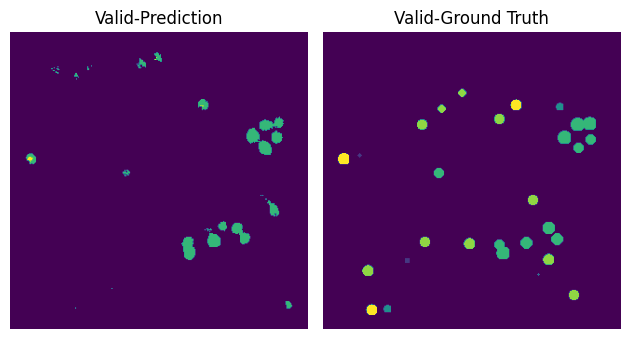

Valid-Epoch: 3, Loss: 0.05467757544702972:  92%|█████████▏| 184/200 [00:08<00:00, 22.41it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 3, VALID_SCORE: 0.06866053086317193


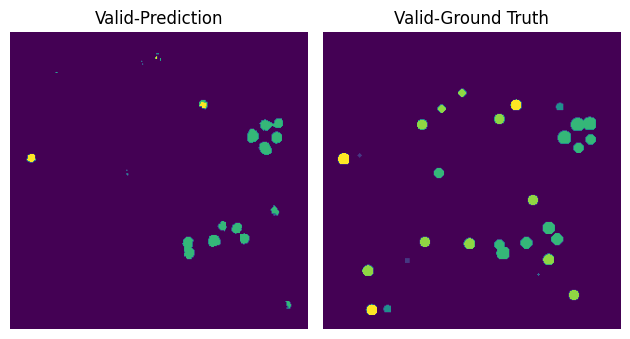

Valid-Epoch: 4, Loss: 0.06395627345646852:  92%|█████████▏| 184/200 [00:08<00:00, 22.61it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 4, VALID_SCORE: 0.03629267175157585


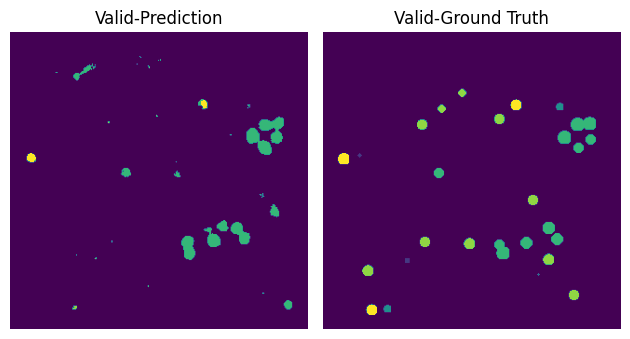

Valid-Epoch: 5, Loss: 0.060820871494639585:  92%|█████████▏| 184/200 [00:08<00:00, 20.75it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 5, VALID_SCORE: 0.031051155004774136


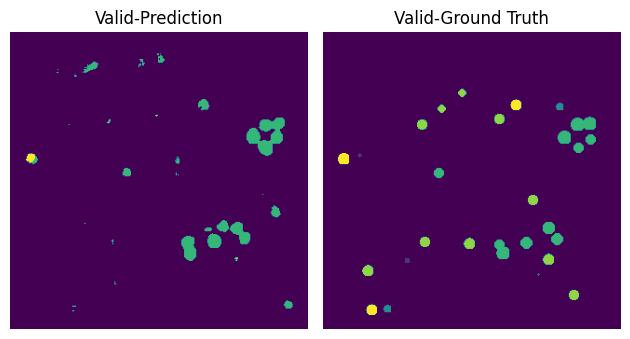

Valid-Epoch: 6, Loss: 0.08113638571914002:  92%|█████████▏| 184/200 [00:08<00:00, 21.36it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 6, VALID_SCORE: 0.16544276177581937


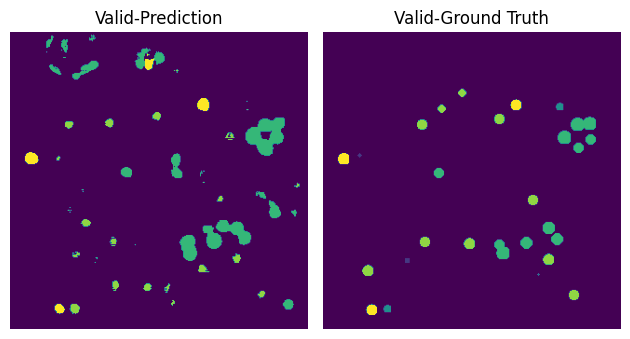

Valid-Epoch: 7, Loss: 0.059156544455934476:  92%|█████████▏| 184/200 [00:08<00:00, 22.74it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 7, VALID_SCORE: 0.16277316260537755


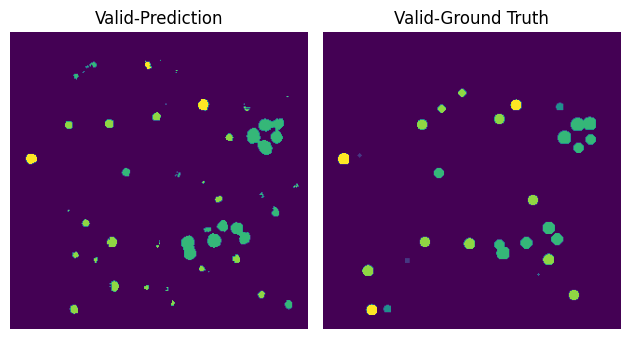

Valid-Epoch: 8, Loss: 0.061958526354789246:  92%|█████████▏| 184/200 [00:08<00:00, 22.49it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 8, VALID_SCORE: 0.17054915244910762


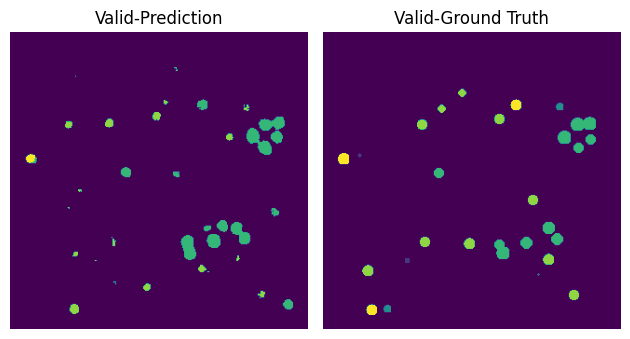

Valid-Epoch: 9, Loss: 0.06272302907208264:  92%|█████████▏| 184/200 [00:08<00:00, 21.75it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 9, VALID_SCORE: 0.050522423717240264


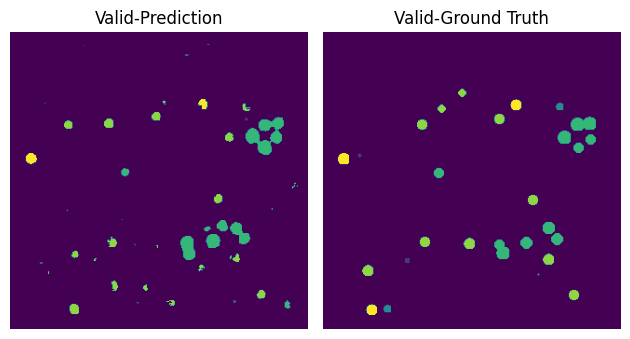

Valid-Epoch: 10, Loss: 0.04204675295256058:  92%|█████████▏| 184/200 [00:08<00:00, 22.33it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 10, VALID_SCORE: 0.11273798261380544


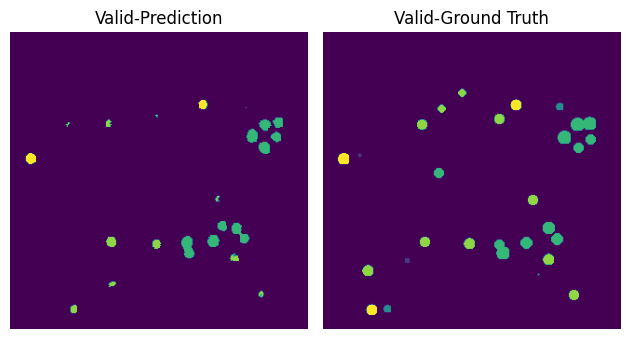

Valid-Epoch: 11, Loss: 0.07698717721581014:  92%|█████████▏| 184/200 [00:08<00:00, 22.46it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 11, VALID_SCORE: 0.016148434121595577


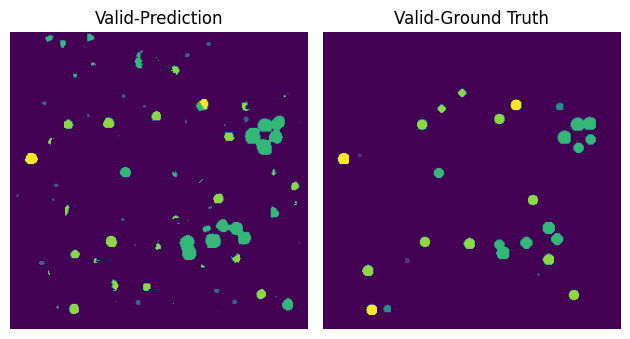

Valid-Epoch: 12, Loss: 0.043703225560223116:  92%|█████████▏| 184/200 [00:08<00:00, 21.50it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 12, VALID_SCORE: 0.031015558258149403


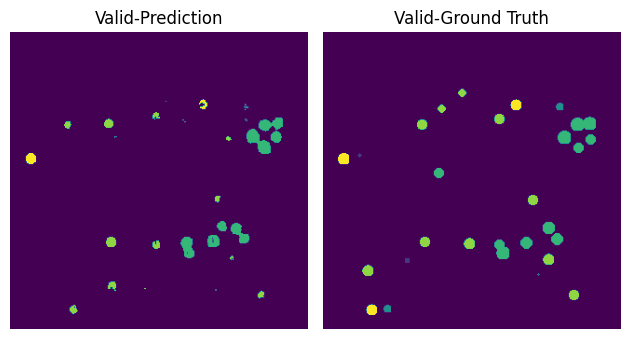

Valid-Epoch: 13, Loss: 0.0925939838229881:  92%|█████████▏| 184/200 [00:08<00:00, 22.45it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 13, VALID_SCORE: 0.02317811316647236


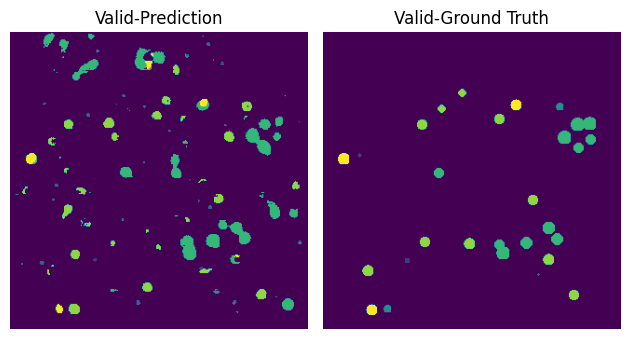

Valid-Epoch: 14, Loss: 0.05660603094830825:  92%|█████████▏| 184/200 [00:08<00:00, 21.50it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 14, VALID_SCORE: 0.0174053050486861


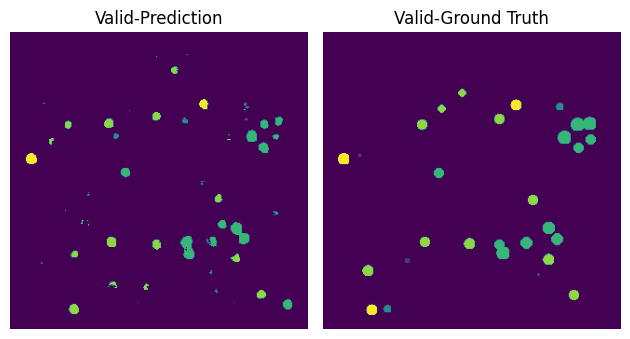

Valid-Epoch: 15, Loss: 0.06730581700116012:  92%|█████████▏| 184/200 [00:08<00:00, 22.68it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 15, VALID_SCORE: 0.025270208499073042


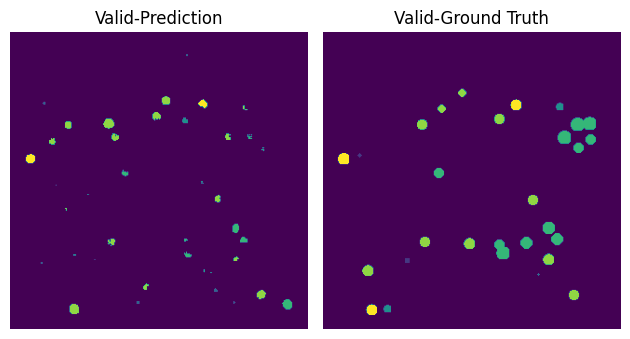

Valid-Epoch: 16, Loss: 0.09641365886352066:  92%|█████████▏| 184/200 [00:08<00:00, 22.65it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 16, VALID_SCORE: 0.025360996574471675


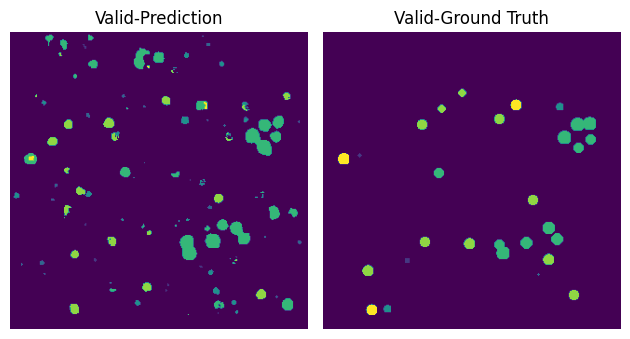

Valid-Epoch: 17, Loss: 0.044997928164894285:  92%|█████████▏| 184/200 [00:08<00:00, 22.74it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 17, VALID_SCORE: 0.02717322880418974


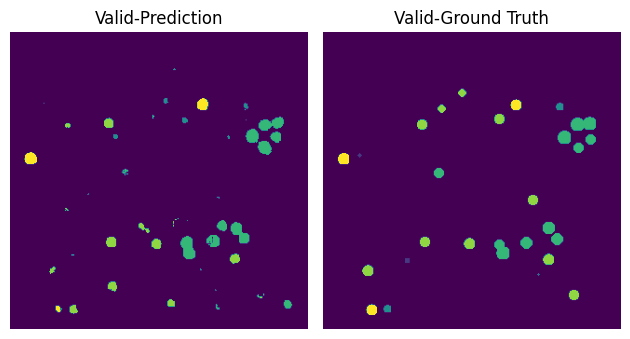

Valid-Epoch: 18, Loss: 0.0461579697603947:  92%|█████████▏| 184/200 [00:08<00:00, 22.30it/s]  


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 18, VALID_SCORE: 0.023191345360484207


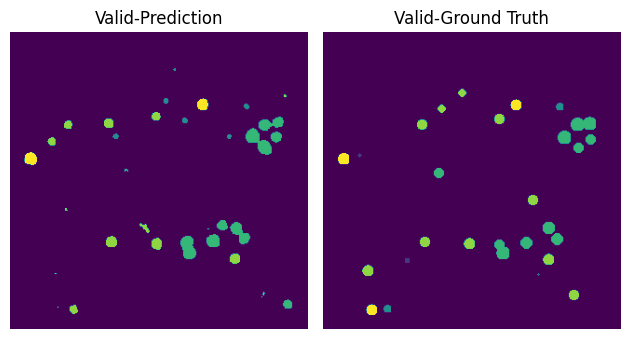

Valid-Epoch: 19, Loss: 0.06444558783076228:  92%|█████████▏| 184/200 [00:08<00:00, 22.75it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 19, VALID_SCORE: 0.021367159125928348


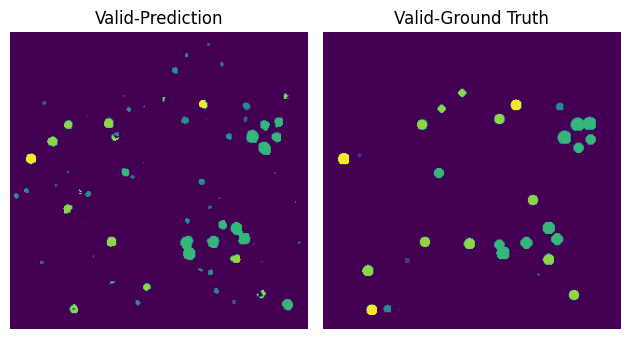

Valid-Epoch: 20, Loss: 0.05925752559699543:  92%|█████████▏| 184/200 [00:07<00:00, 23.03it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 20, VALID_SCORE: 0.016293141083940466


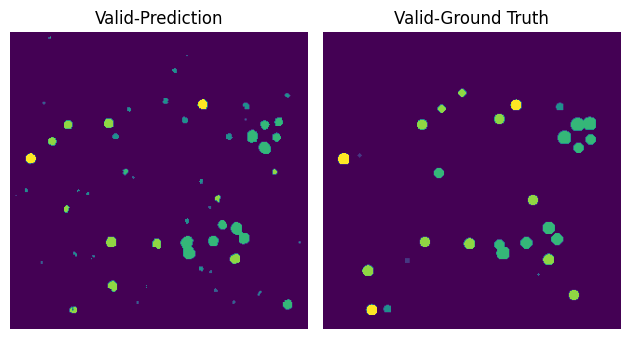

Valid-Epoch: 21, Loss: 0.06365403957534:  92%|█████████▏| 184/200 [00:08<00:00, 22.49it/s]    


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 21, VALID_SCORE: 0.018545425047799467


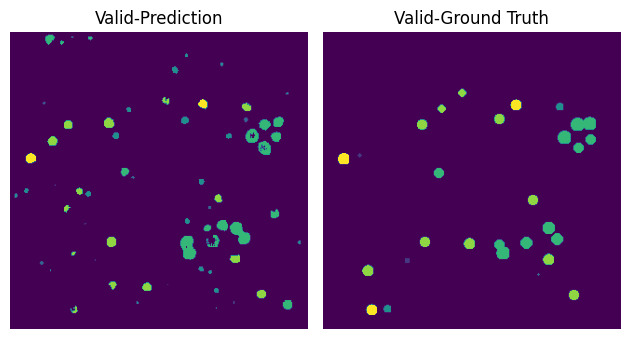

Valid-Epoch: 22, Loss: 0.2091309985161111:  92%|█████████▏| 184/200 [00:08<00:00, 22.94it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 22, VALID_SCORE: 0.02811767119901947


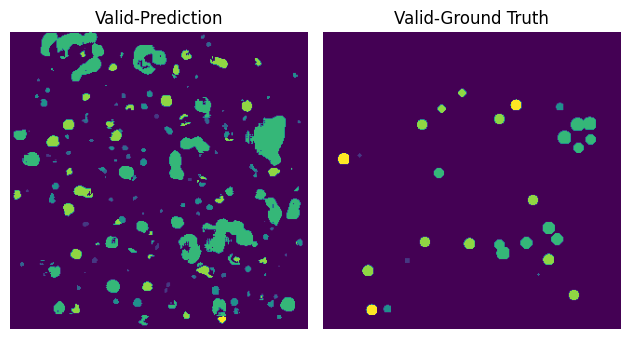

Valid-Epoch: 23, Loss: 0.21878841904538643:  92%|█████████▏| 184/200 [00:08<00:00, 22.28it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 23, VALID_SCORE: 0.027086447849105185


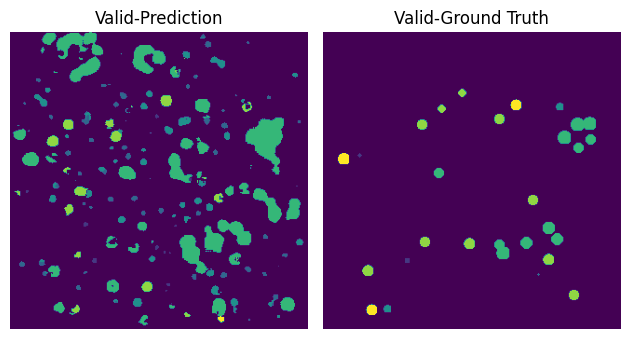

Valid-Epoch: 24, Loss: 0.17540439087821616:  92%|█████████▏| 184/200 [00:08<00:00, 22.00it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 24, VALID_SCORE: 0.027945962103758073


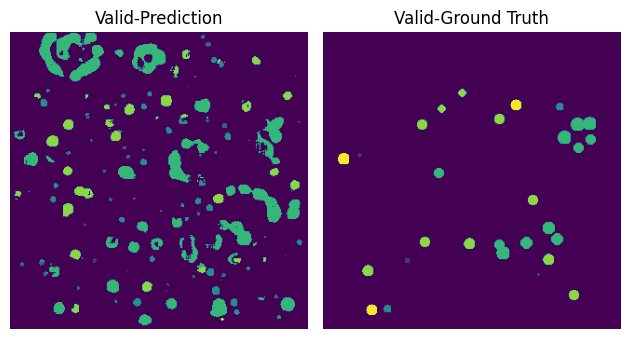

Valid-Epoch: 25, Loss: 0.05524726254525771:  92%|█████████▏| 184/200 [00:08<00:00, 20.75it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 25, VALID_SCORE: 0.022880986997375907


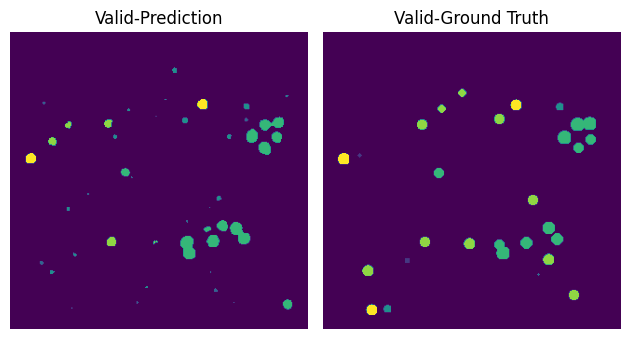

Valid-Epoch: 26, Loss: 0.0887195219416437:  92%|█████████▏| 184/200 [00:08<00:00, 22.29it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 26, VALID_SCORE: 0.03037605503554732


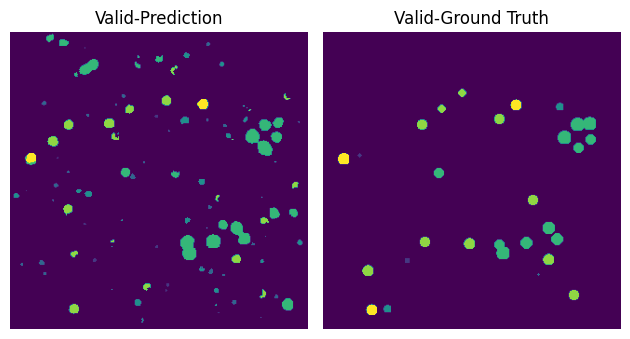

Valid-Epoch: 27, Loss: 0.052616020132953294:  92%|█████████▏| 184/200 [00:08<00:00, 21.97it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 27, VALID_SCORE: 0.024612811676349104


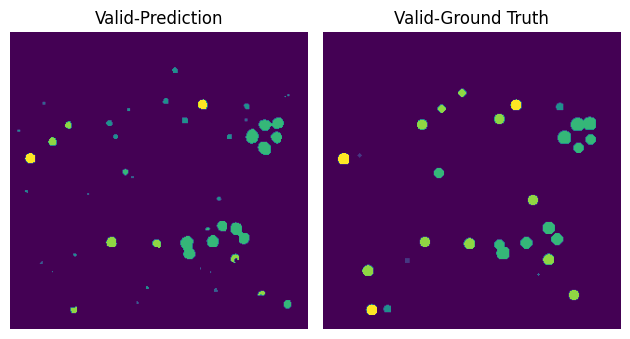

Valid-Epoch: 28, Loss: 0.06550009740860095:  92%|█████████▏| 184/200 [00:08<00:00, 22.88it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 28, VALID_SCORE: 0.018860637323877258


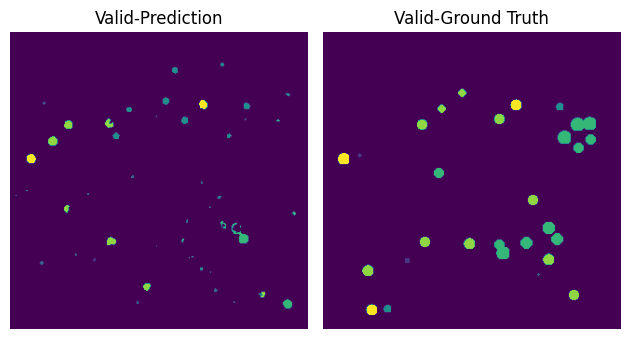

Valid-Epoch: 29, Loss: 0.05000083951262755:  92%|█████████▏| 184/200 [00:08<00:00, 22.72it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 29, VALID_SCORE: 0.027792316449957544


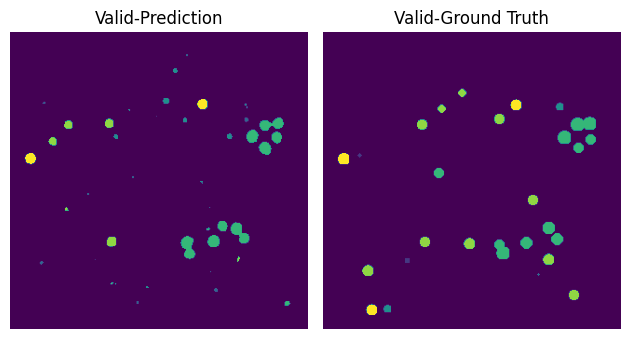

Valid-Epoch: 30, Loss: 0.12447930541352632:  92%|█████████▏| 184/200 [00:07<00:00, 23.01it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 30, VALID_SCORE: 0.03082447239432562


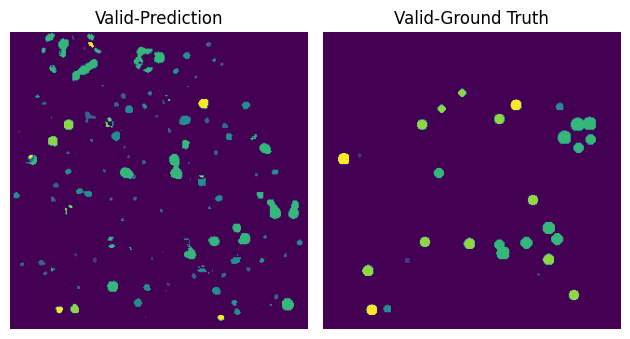

Valid-Epoch: 31, Loss: 0.05465637295885798:  92%|█████████▏| 184/200 [00:08<00:00, 22.89it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 31, VALID_SCORE: 0.024816886285189486


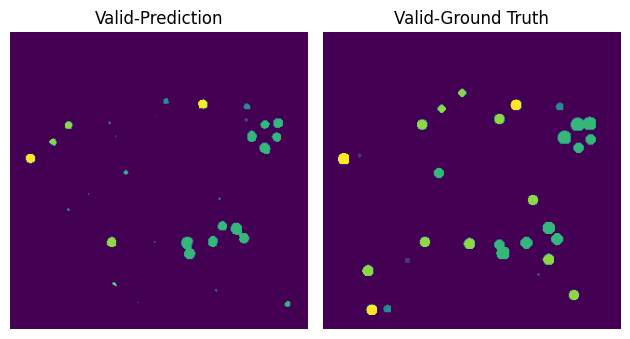

Valid-Epoch: 32, Loss: 0.09869822753092233:  92%|█████████▏| 184/200 [00:08<00:00, 22.78it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 32, VALID_SCORE: 0.02475371415259868


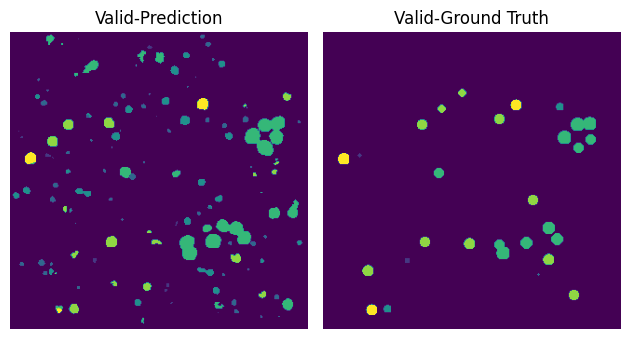

Valid-Epoch: 33, Loss: 0.052716742529414856:  92%|█████████▏| 184/200 [00:08<00:00, 22.93it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 33, VALID_SCORE: 0.015740918367896452


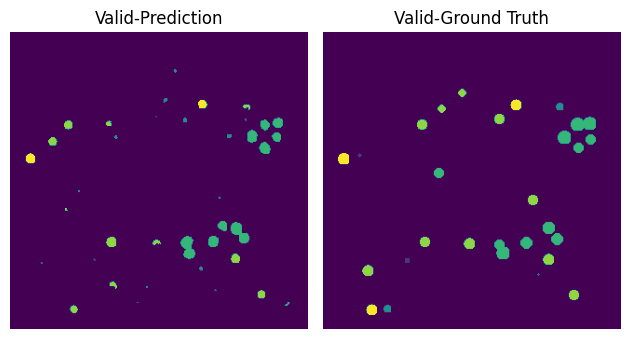

Valid-Epoch: 34, Loss: 0.05549238602424853:  92%|█████████▏| 184/200 [00:08<00:00, 22.34it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 34, VALID_SCORE: 0.032091109335650465


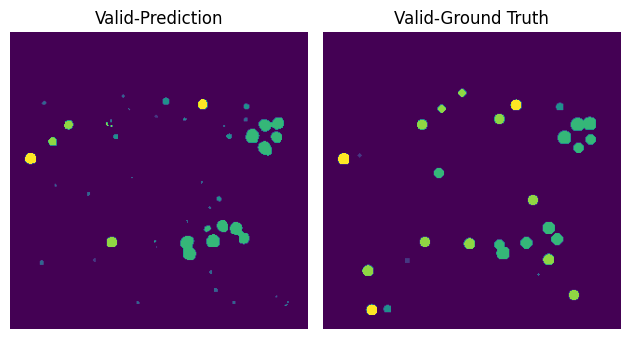

Valid-Epoch: 35, Loss: 0.06646062754124733:  92%|█████████▏| 184/200 [00:08<00:00, 22.80it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 35, VALID_SCORE: 0.032464006934980125


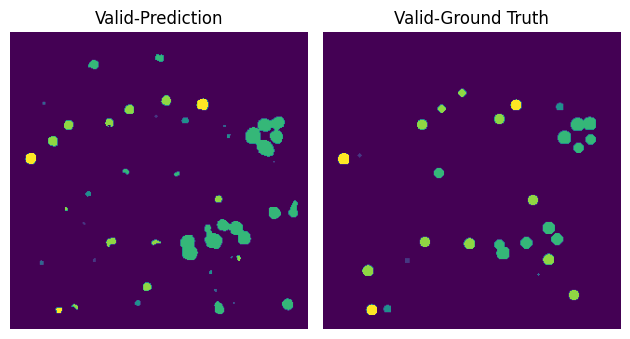

Valid-Epoch: 36, Loss: 0.056450038918960076:  92%|█████████▏| 184/200 [00:08<00:00, 22.39it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 36, VALID_SCORE: 0.03554341954343679


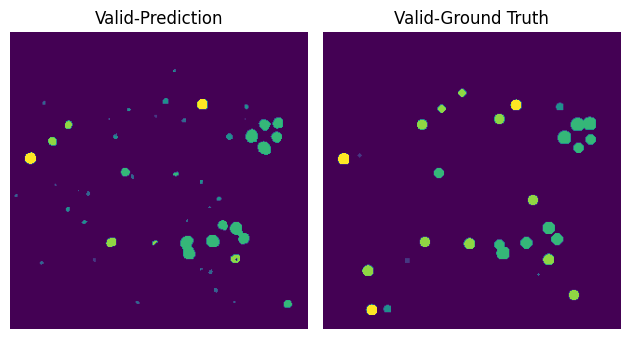

Valid-Epoch: 37, Loss: 0.06737151124343654:  92%|█████████▏| 184/200 [00:08<00:00, 22.96it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 37, VALID_SCORE: 0.01669384756676692


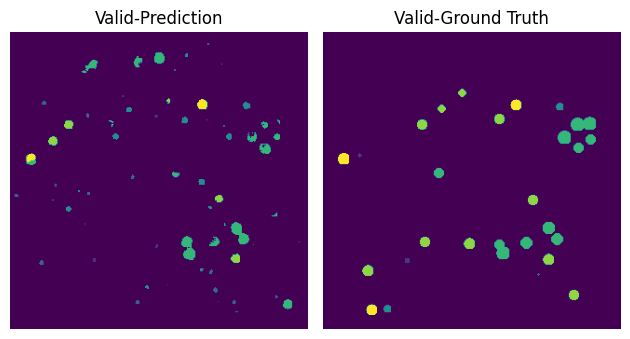

Valid-Epoch: 38, Loss: 0.06272201841586691:  92%|█████████▏| 184/200 [00:07<00:00, 23.15it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 38, VALID_SCORE: 0.017514367729507332


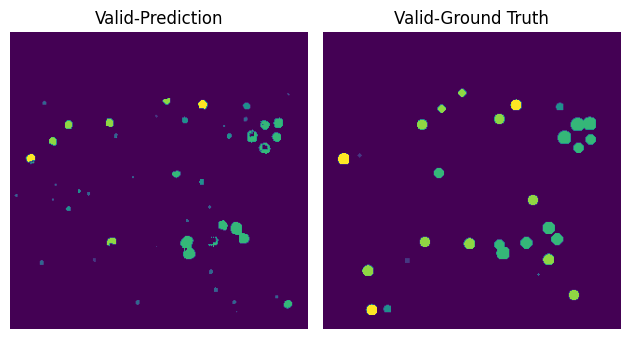

Valid-Epoch: 39, Loss: 0.0683327964937274:  92%|█████████▏| 184/200 [00:08<00:00, 21.79it/s]  


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 39, VALID_SCORE: 0.02134865964749639


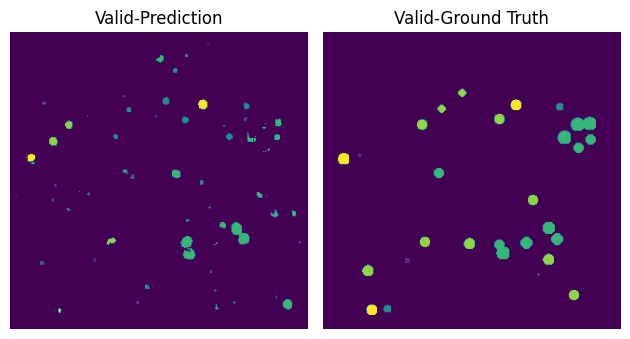

Valid-Epoch: 40, Loss: 0.06378891607888047:  92%|█████████▏| 184/200 [00:08<00:00, 22.76it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 40, VALID_SCORE: 0.01777289934784202


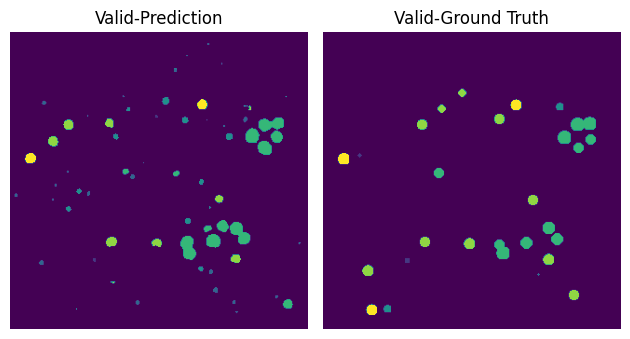

Valid-Epoch: 41, Loss: 0.20835856430462824:  92%|█████████▏| 184/200 [00:07<00:00, 23.02it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 41, VALID_SCORE: 0.026766126369509577


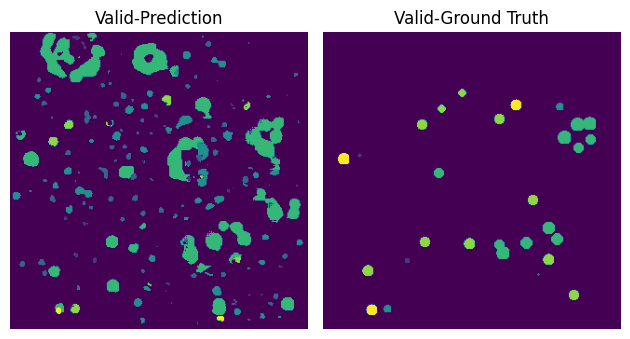

Valid-Epoch: 42, Loss: 0.15276849753117067:  92%|█████████▏| 184/200 [00:08<00:00, 22.40it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 42, VALID_SCORE: 0.030753370009172352


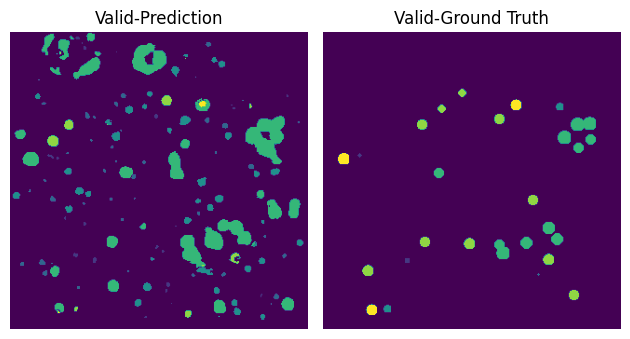

Valid-Epoch: 43, Loss: 0.05344589139422564:  92%|█████████▏| 184/200 [00:07<00:00, 23.26it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 43, VALID_SCORE: 0.02483341039936133


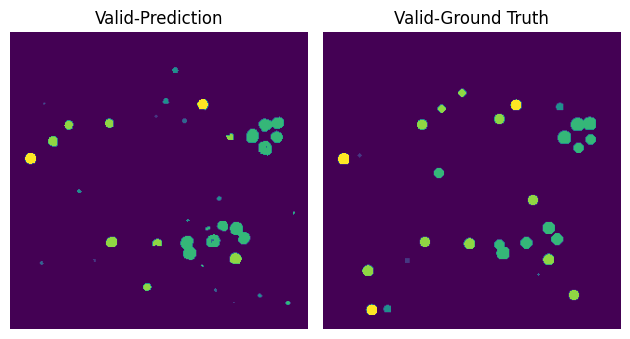

Valid-Epoch: 44, Loss: 0.07666142094920202:  92%|█████████▏| 184/200 [00:08<00:00, 22.54it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 44, VALID_SCORE: 0.04146563708508538


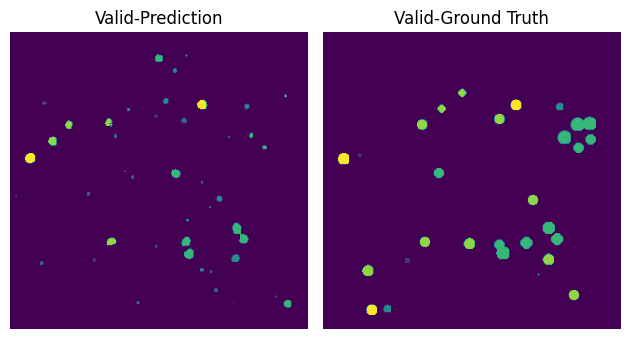

Valid-Epoch: 45, Loss: 0.07694141840017002:  92%|█████████▏| 184/200 [00:08<00:00, 22.91it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 45, VALID_SCORE: 0.021635280921350072


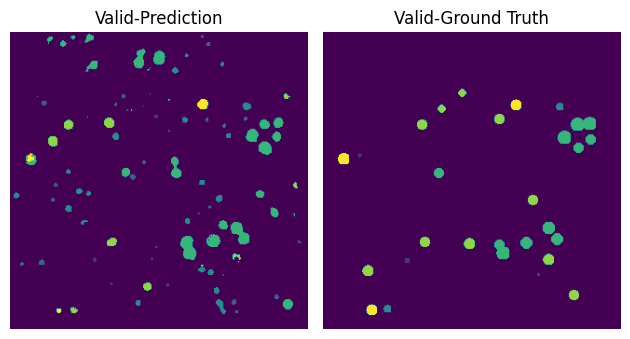

Valid-Epoch: 46, Loss: 0.05873308172506412:  92%|█████████▏| 184/200 [00:08<00:00, 22.33it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 46, VALID_SCORE: 0.016180635255899408


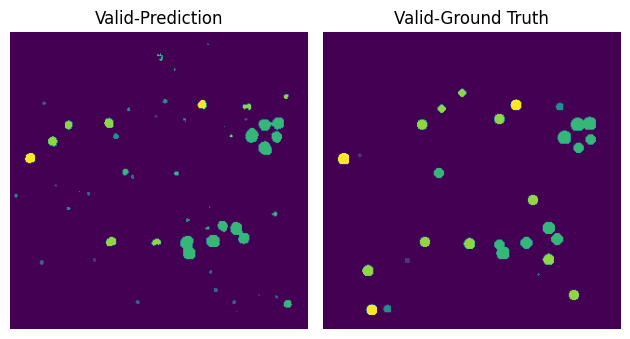

Valid-Epoch: 47, Loss: 0.05472788165663745:  92%|█████████▏| 184/200 [00:08<00:00, 22.78it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 47, VALID_SCORE: 0.020236407543388686


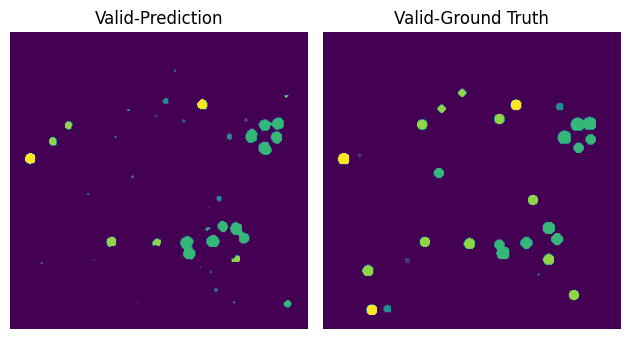

Valid-Epoch: 48, Loss: 0.07320681788089291:  92%|█████████▏| 184/200 [00:08<00:00, 21.76it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 48, VALID_SCORE: 0.02362308041145587


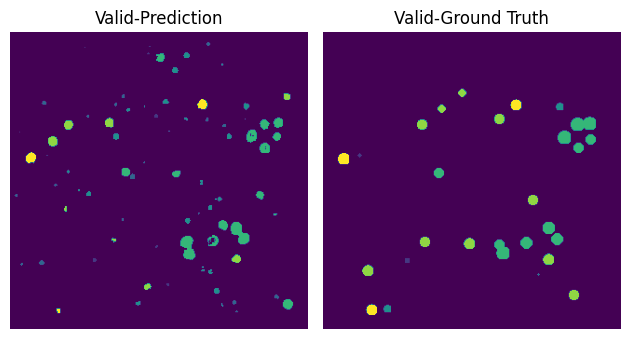

Valid-Epoch: 49, Loss: 0.05443595073979455:  92%|█████████▏| 184/200 [00:08<00:00, 22.53it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 49, VALID_SCORE: 0.0423752920557279


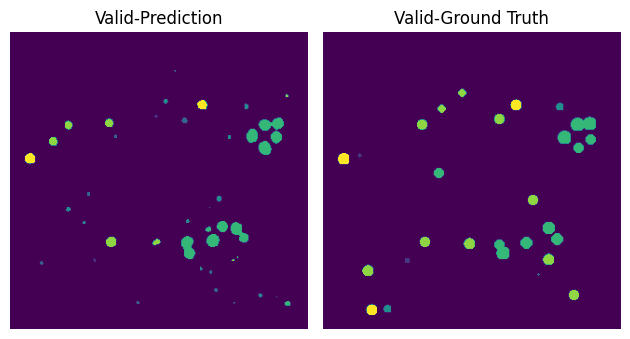

Valid-Epoch: 50, Loss: 0.054414102146240664:  92%|█████████▏| 184/200 [00:08<00:00, 22.26it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 50, VALID_SCORE: 0.024270188635719718


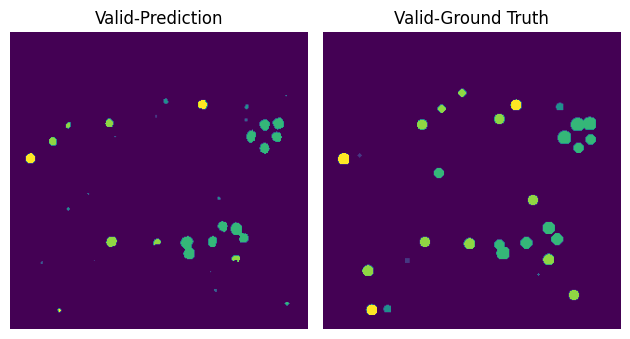

Valid-Epoch: 51, Loss: 0.05692377489857909:  92%|█████████▏| 184/200 [00:08<00:00, 22.70it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 51, VALID_SCORE: 0.02156578273385869


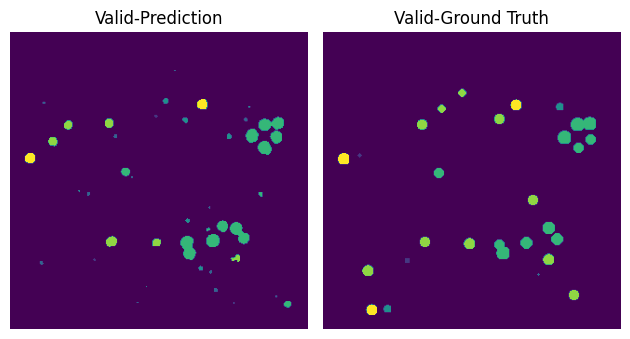

Valid-Epoch: 52, Loss: 0.08693687315494374:  92%|█████████▏| 184/200 [00:08<00:00, 22.47it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 52, VALID_SCORE: 0.02145463921218237


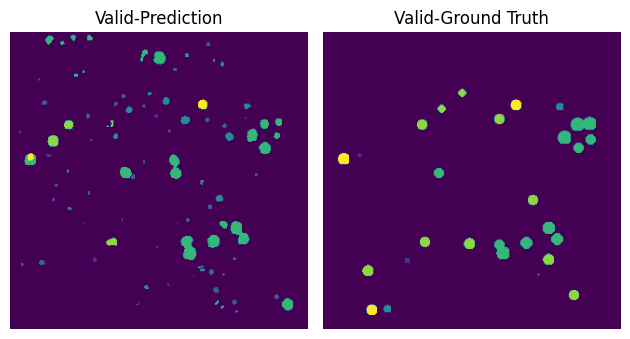

Valid-Epoch: 53, Loss: 0.10811028817158291:  92%|█████████▏| 184/200 [00:08<00:00, 22.36it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 53, VALID_SCORE: 0.030364509583682718


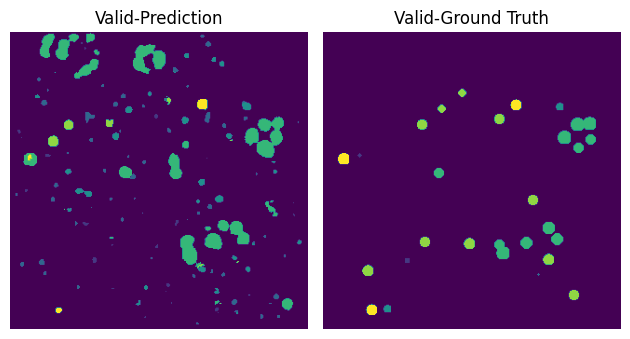

Valid-Epoch: 54, Loss: 0.06091625574971777:  92%|█████████▏| 184/200 [00:08<00:00, 22.60it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 54, VALID_SCORE: 0.046992315375934804


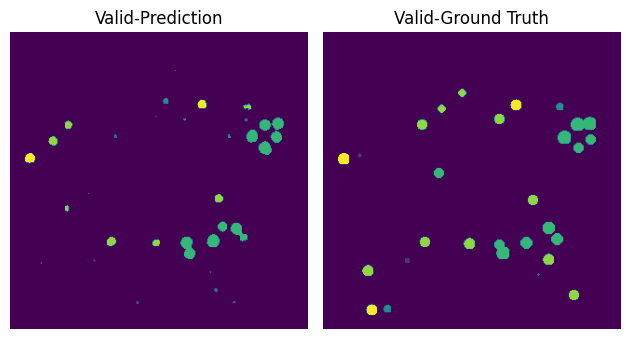

Valid-Epoch: 55, Loss: 0.08712357378720734:  92%|█████████▏| 184/200 [00:08<00:00, 22.46it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 55, VALID_SCORE: 0.01787869710269532


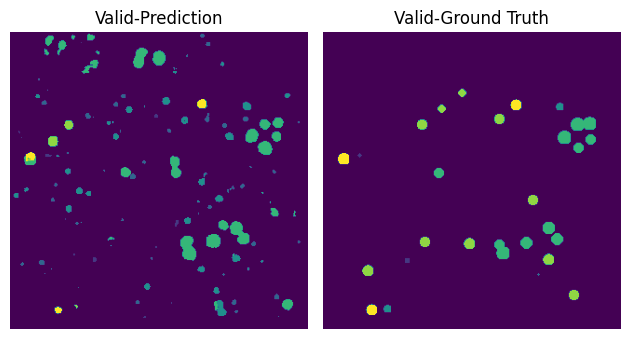

Valid-Epoch: 56, Loss: 0.06901833956427926:  92%|█████████▏| 184/200 [00:08<00:00, 22.08it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 56, VALID_SCORE: 0.022063388902432514


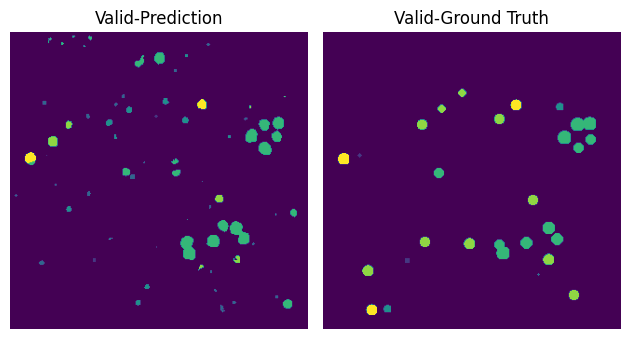

Valid-Epoch: 57, Loss: 0.06001464041231014:  92%|█████████▏| 184/200 [00:07<00:00, 23.10it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 57, VALID_SCORE: 0.023461843645795188


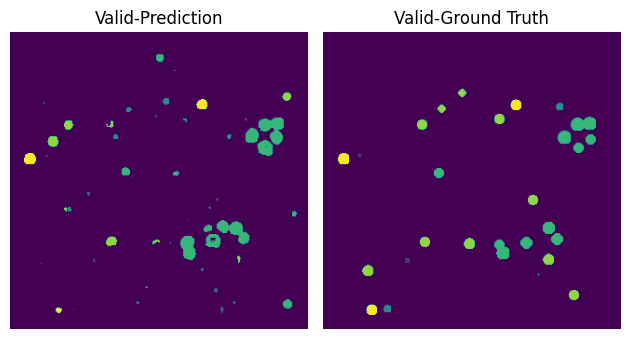

Valid-Epoch: 58, Loss: 0.05668074200975357:  92%|█████████▏| 184/200 [00:08<00:00, 21.72it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 58, VALID_SCORE: 0.02757786065851648


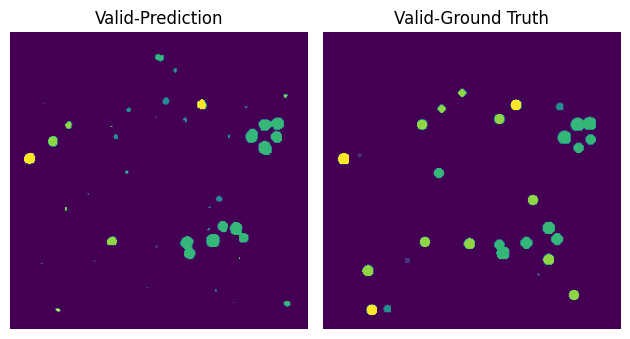

Valid-Epoch: 59, Loss: 0.06096529346155955:  92%|█████████▏| 184/200 [00:08<00:00, 22.81it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 59, VALID_SCORE: 0.04335140596016393


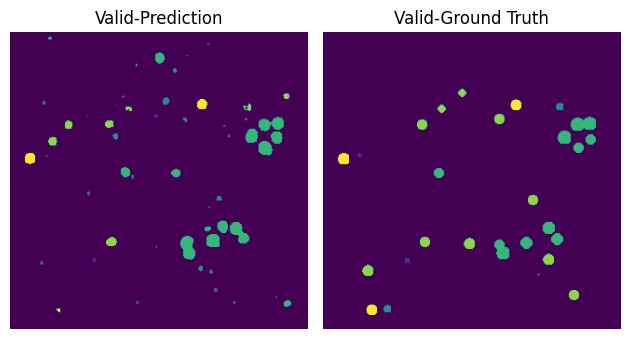

Valid-Epoch: 60, Loss: 0.05872263160691822:  92%|█████████▏| 184/200 [00:07<00:00, 23.15it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 60, VALID_SCORE: 0.022453856003540787


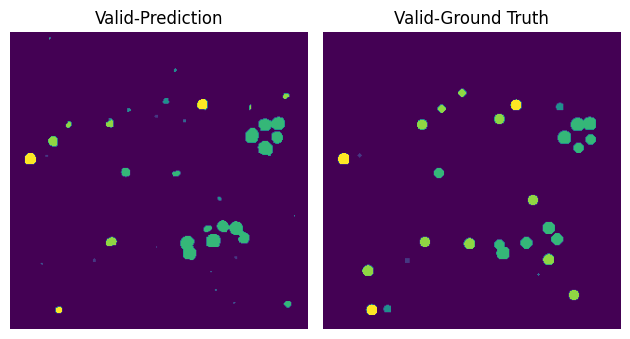

Valid-Epoch: 61, Loss: 0.06757561455054636:  92%|█████████▏| 184/200 [00:08<00:00, 22.23it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 61, VALID_SCORE: 0.037142840835671646


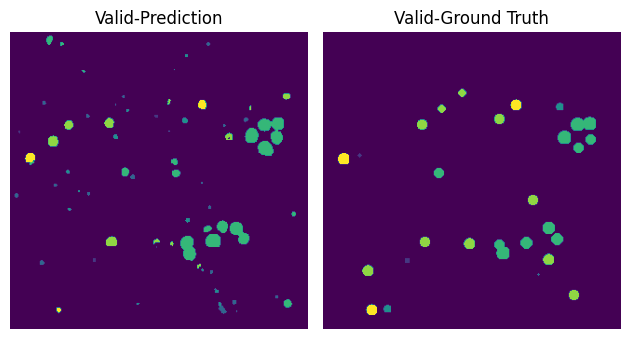

Valid-Epoch: 62, Loss: 0.07648516080260616:  92%|█████████▏| 184/200 [00:08<00:00, 22.73it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 62, VALID_SCORE: 0.02389876107366798


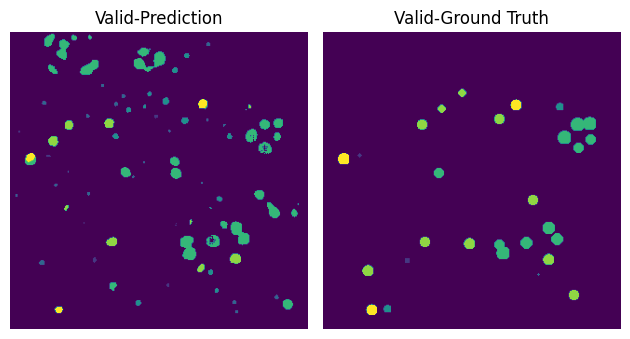

Valid-Epoch: 63, Loss: 0.05665689696525078:  92%|█████████▏| 184/200 [00:08<00:00, 22.06it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 63, VALID_SCORE: 0.02340936327142338


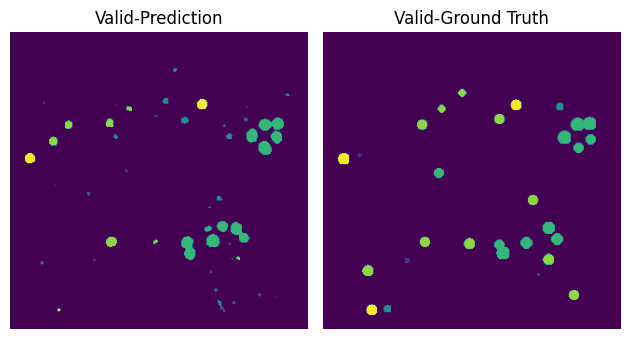

Valid-Epoch: 64, Loss: 0.061304864760606266:  92%|█████████▏| 184/200 [00:08<00:00, 22.27it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 64, VALID_SCORE: 0.04792934642604934


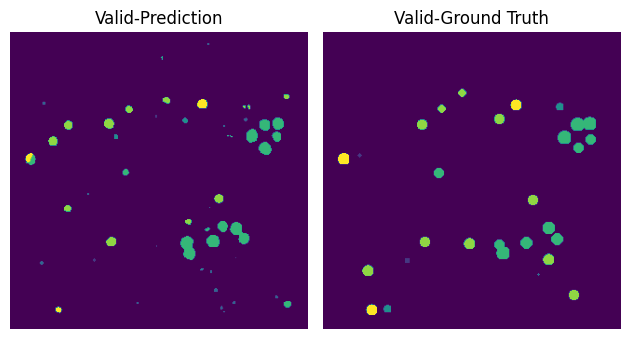

Valid-Epoch: 65, Loss: 0.11561298792224514:  92%|█████████▏| 184/200 [00:08<00:00, 21.81it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 65, VALID_SCORE: 0.025320906779498508


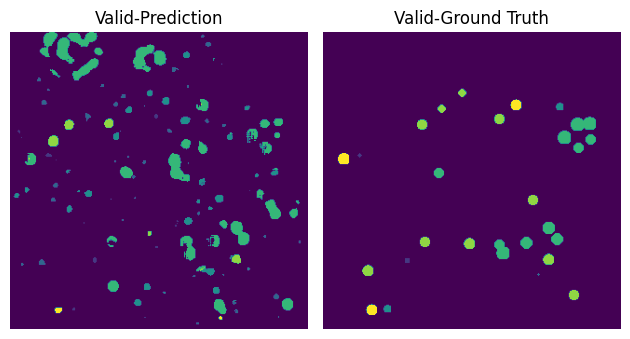

Valid-Epoch: 66, Loss: 0.11163369983498105:  92%|█████████▏| 184/200 [00:08<00:00, 22.82it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 66, VALID_SCORE: 0.026802518013464116


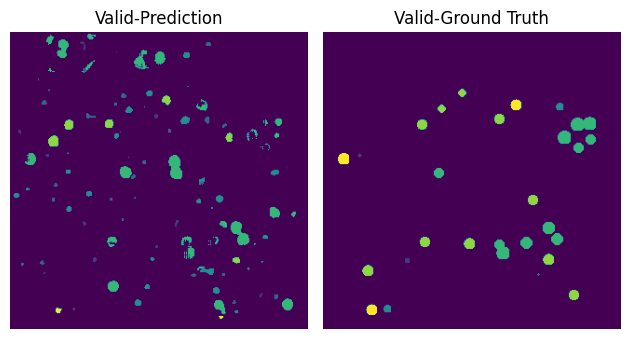

Valid-Epoch: 67, Loss: 0.05906002491631467:  92%|█████████▏| 184/200 [00:08<00:00, 22.16it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 67, VALID_SCORE: 0.03848238150978975


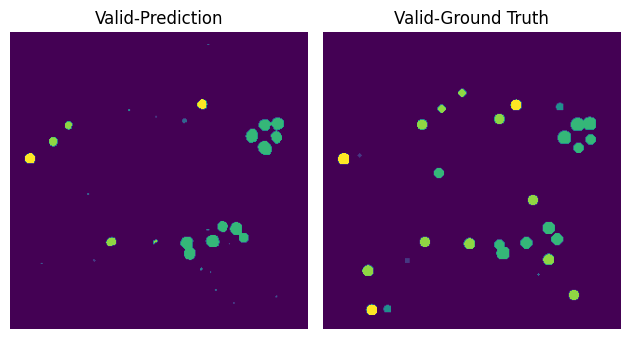

Valid-Epoch: 68, Loss: 0.06046238967339535:  92%|█████████▏| 184/200 [00:08<00:00, 22.46it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 68, VALID_SCORE: 0.02472622491802491


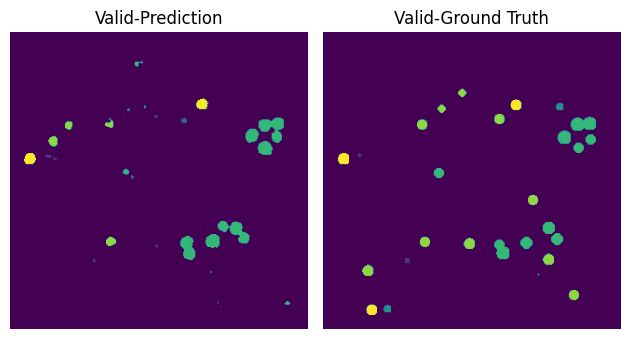

Valid-Epoch: 69, Loss: 0.11284786885979607:  92%|█████████▏| 184/200 [00:08<00:00, 21.05it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 69, VALID_SCORE: 0.04329097004525648


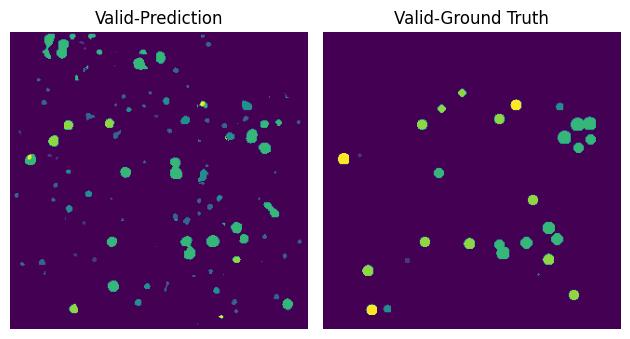

Valid-Epoch: 70, Loss: 0.06832505856290601:  92%|█████████▏| 184/200 [00:08<00:00, 22.77it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 70, VALID_SCORE: 0.028400449772723324


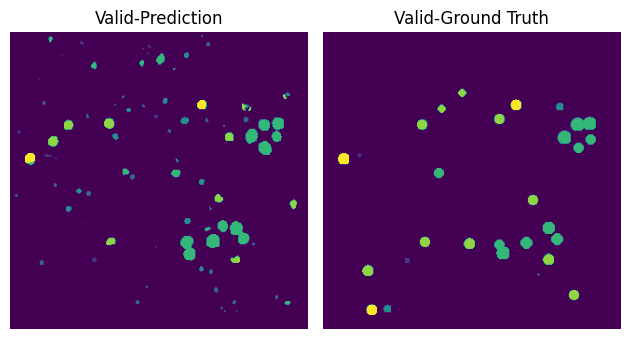

Valid-Epoch: 71, Loss: 0.056283087823846036:  92%|█████████▏| 184/200 [00:08<00:00, 22.73it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 71, VALID_SCORE: 0.028556817042617012


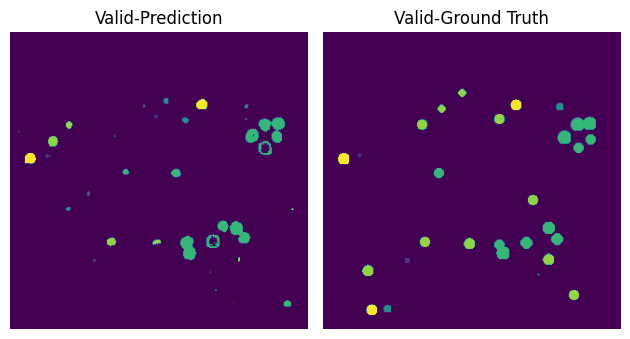

Valid-Epoch: 72, Loss: 0.06388011837122537:  92%|█████████▏| 184/200 [00:08<00:00, 22.89it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 72, VALID_SCORE: 0.0435441924349641


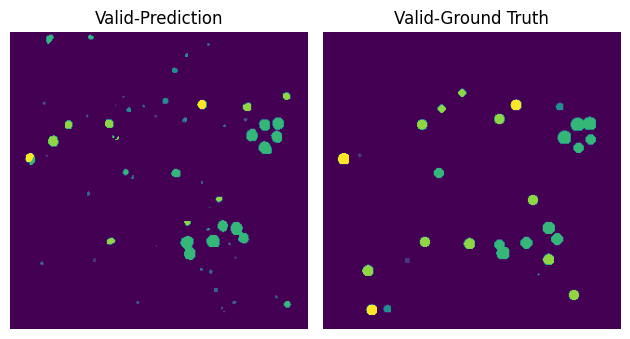

Valid-Epoch: 73, Loss: 0.058978020193614575:  92%|█████████▏| 184/200 [00:08<00:00, 21.43it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 73, VALID_SCORE: 0.02228864969641355


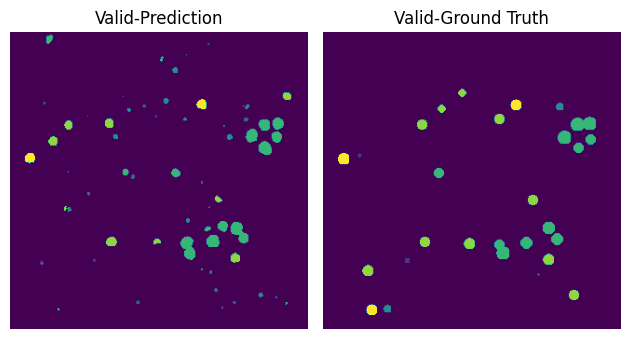

Valid-Epoch: 74, Loss: 0.06189022190538589:  92%|█████████▏| 184/200 [00:08<00:00, 22.23it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 74, VALID_SCORE: 0.037167984813625196


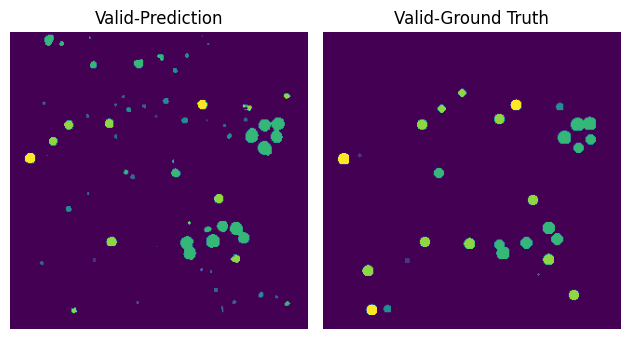

Valid-Epoch: 75, Loss: 0.0699958717862639:  92%|█████████▏| 184/200 [00:08<00:00, 22.87it/s]  


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 75, VALID_SCORE: 0.02580256538823656


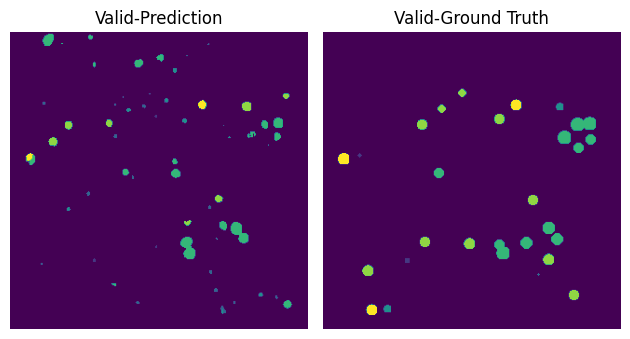

Valid-Epoch: 76, Loss: 0.06147391521280161:  92%|█████████▏| 184/200 [00:07<00:00, 23.17it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 76, VALID_SCORE: 0.030519252817918098


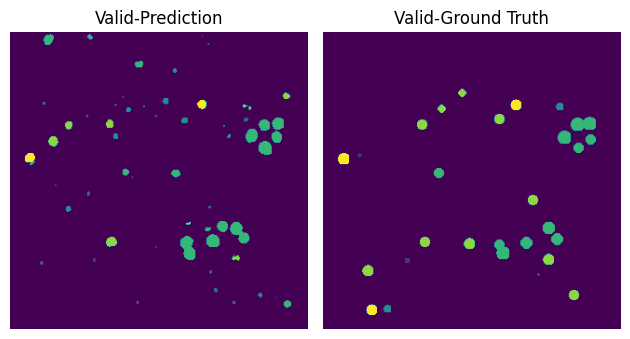

Valid-Epoch: 77, Loss: 0.07661183805398848:  92%|█████████▏| 184/200 [00:08<00:00, 22.22it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 77, VALID_SCORE: 0.026751640447703645


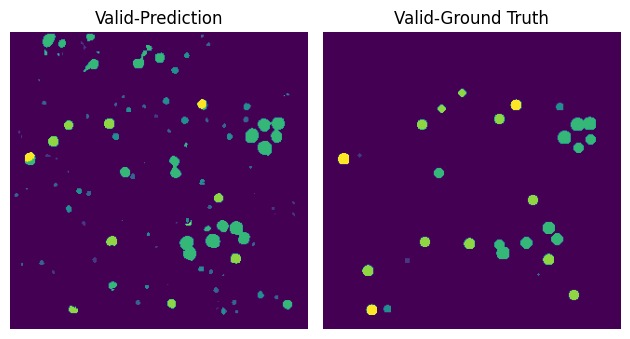

Valid-Epoch: 78, Loss: 0.0660244791988589:  92%|█████████▏| 184/200 [00:08<00:00, 21.24it/s]  


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 78, VALID_SCORE: 0.019283153009809074


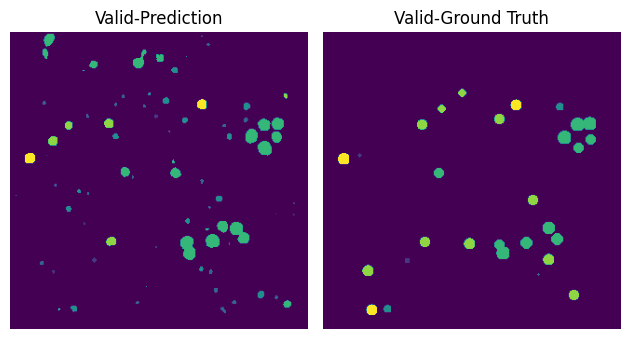

Valid-Epoch: 79, Loss: 0.20587166621028344:  92%|█████████▏| 184/200 [00:07<00:00, 23.35it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 79, VALID_SCORE: 0.022596027979607497


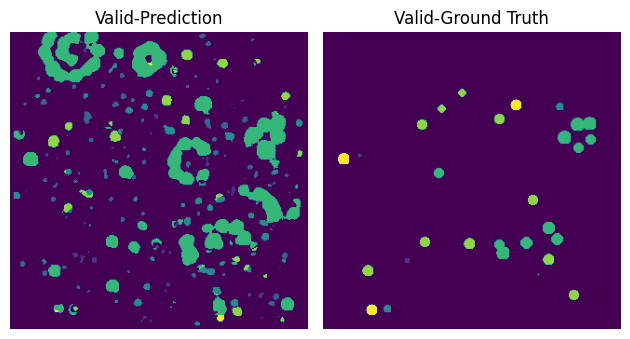

Valid-Epoch: 80, Loss: 0.07059028499837872:  92%|█████████▏| 184/200 [00:08<00:00, 21.85it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 80, VALID_SCORE: 0.027017567267614312


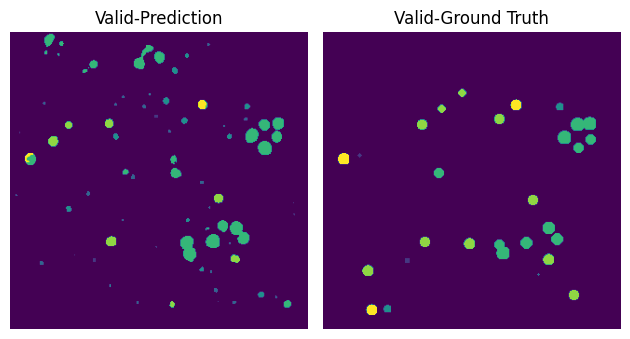

Valid-Epoch: 81, Loss: 0.07163850087899055:  92%|█████████▏| 184/200 [00:08<00:00, 21.58it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 81, VALID_SCORE: 0.047445898395610114


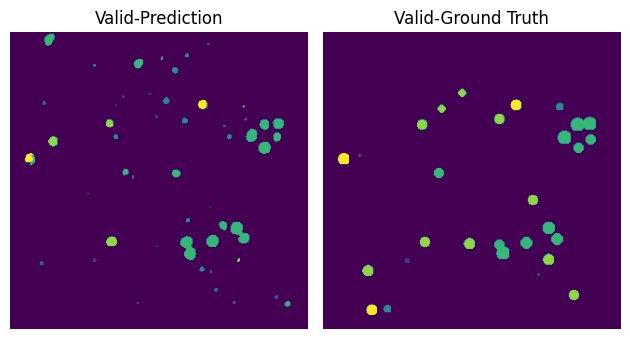

Valid-Epoch: 82, Loss: 0.05986271680585955:  92%|█████████▏| 184/200 [00:08<00:00, 21.86it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 82, VALID_SCORE: 0.035298142946800164


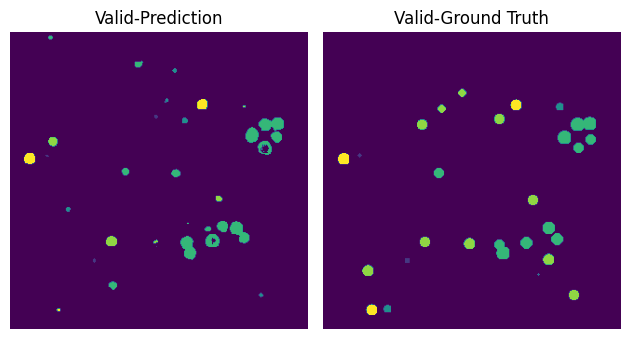

Valid-Epoch: 83, Loss: 0.06143366456968658:  92%|█████████▏| 184/200 [00:08<00:00, 22.56it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 83, VALID_SCORE: 0.018325627193103468


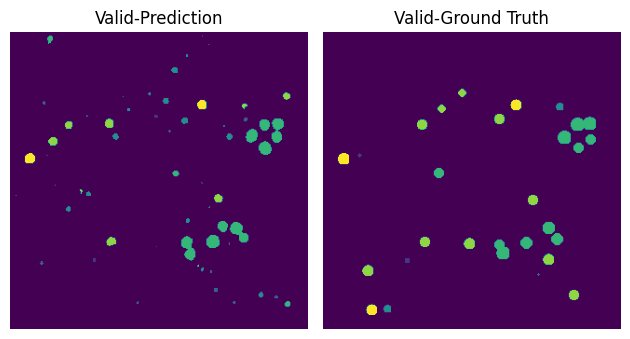

Valid-Epoch: 84, Loss: 0.0809472553827539:  92%|█████████▏| 184/200 [00:08<00:00, 21.38it/s]  


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 84, VALID_SCORE: 0.0271345346186572


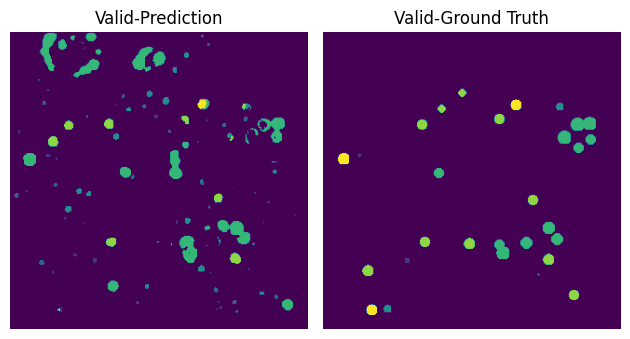

Valid-Epoch: 85, Loss: 0.06741092215831843:  92%|█████████▏| 184/200 [00:08<00:00, 21.97it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 85, VALID_SCORE: 0.03357075805034798


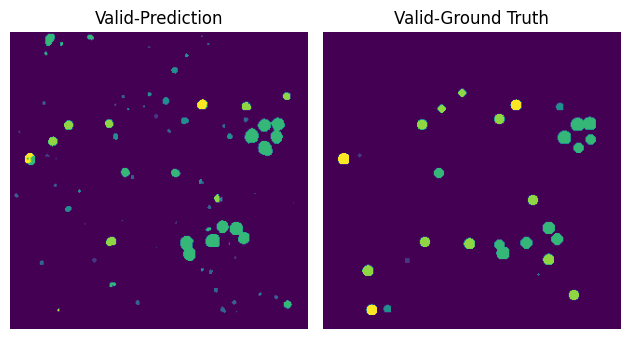

Valid-Epoch: 86, Loss: 0.06330381361308553:  92%|█████████▏| 184/200 [00:08<00:00, 21.82it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 86, VALID_SCORE: 0.02274595911452893


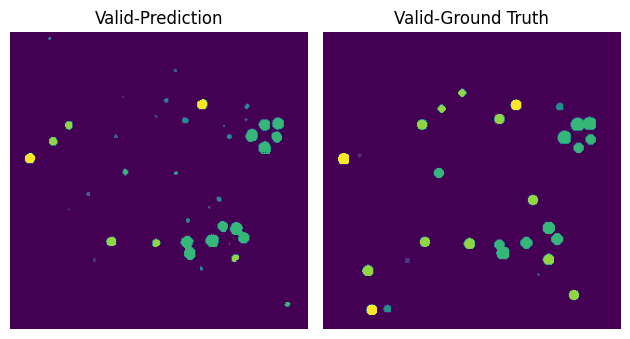

Valid-Epoch: 87, Loss: 0.07138029008023217:  92%|█████████▏| 184/200 [00:08<00:00, 21.91it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 87, VALID_SCORE: 0.041651998657641465


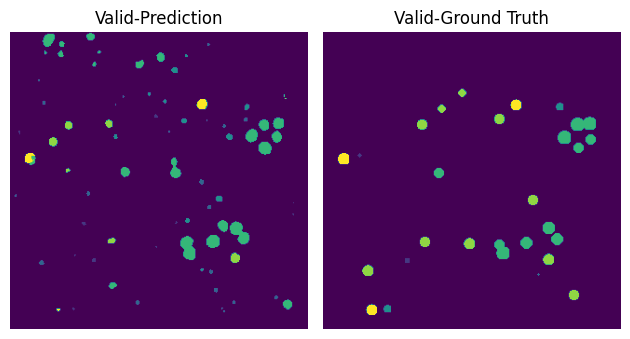

Valid-Epoch: 88, Loss: 0.08744152231951297:  92%|█████████▏| 184/200 [00:08<00:00, 21.97it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 88, VALID_SCORE: 0.024027655991746773


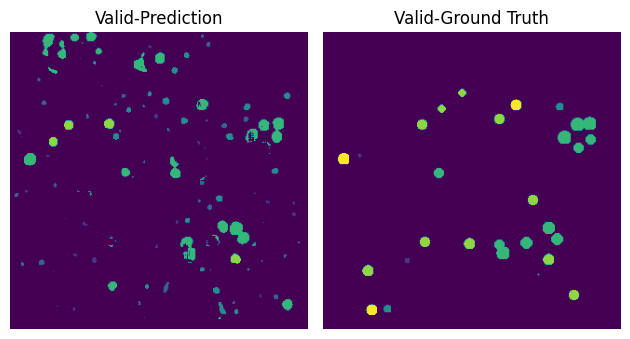

Valid-Epoch: 89, Loss: 0.05909385213534852:  92%|█████████▏| 184/200 [00:08<00:00, 21.91it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 89, VALID_SCORE: 0.023122766105080936


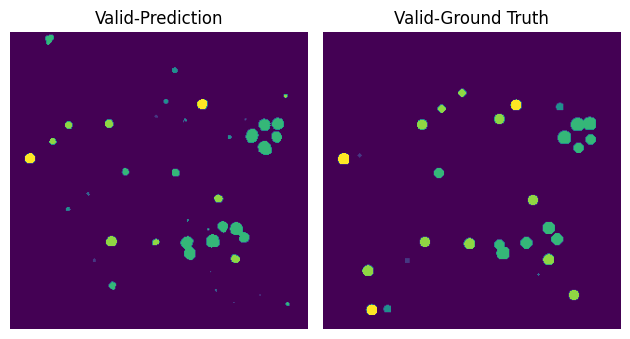

Valid-Epoch: 90, Loss: 0.06235026299224916:  92%|█████████▏| 184/200 [00:08<00:00, 22.32it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 90, VALID_SCORE: 0.01955812987287016


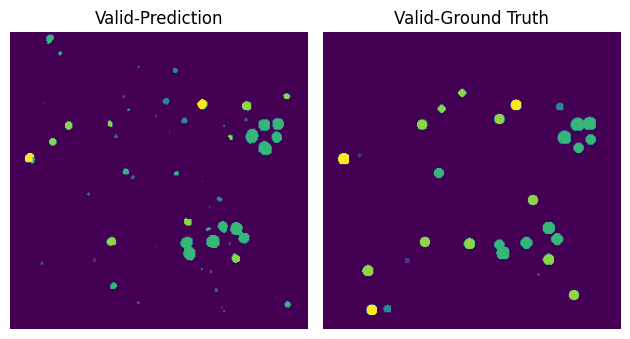

Valid-Epoch: 91, Loss: 0.07977615187685486:  92%|█████████▏| 184/200 [00:08<00:00, 22.63it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 91, VALID_SCORE: 0.029933430750820902


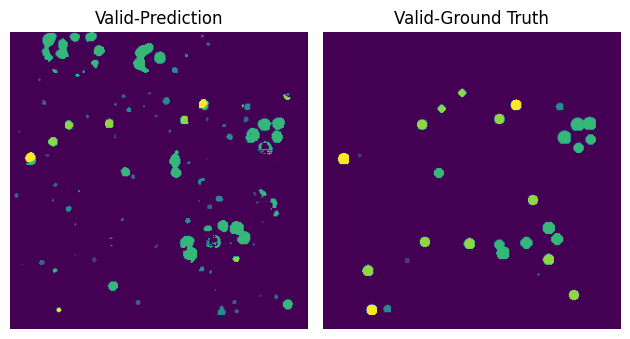

Valid-Epoch: 92, Loss: 0.10572599338494278:  92%|█████████▏| 184/200 [00:08<00:00, 22.32it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 92, VALID_SCORE: 0.027291243103389873


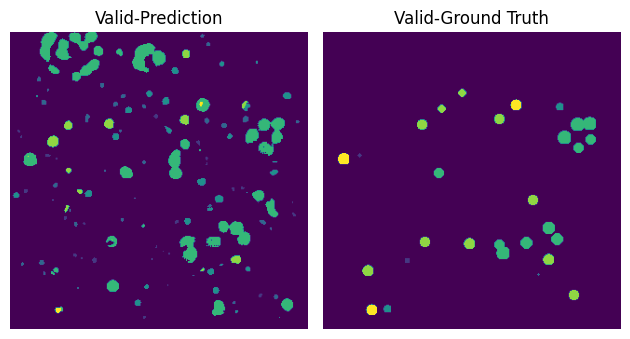

Valid-Epoch: 93, Loss: 0.06670026412921684:  92%|█████████▏| 184/200 [00:08<00:00, 22.51it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 93, VALID_SCORE: 0.0392785627251518


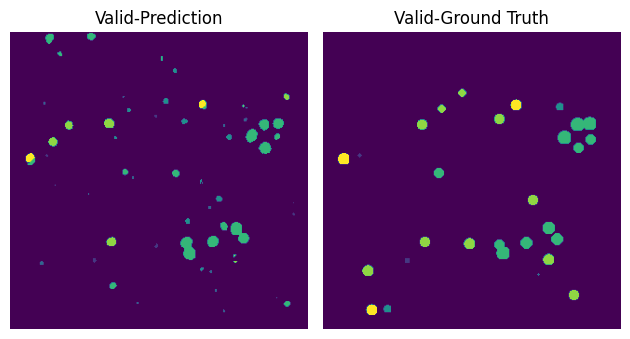

Valid-Epoch: 94, Loss: 0.094338199237862:  92%|█████████▏| 184/200 [00:08<00:00, 22.55it/s]   


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 94, VALID_SCORE: 0.021815797237029394


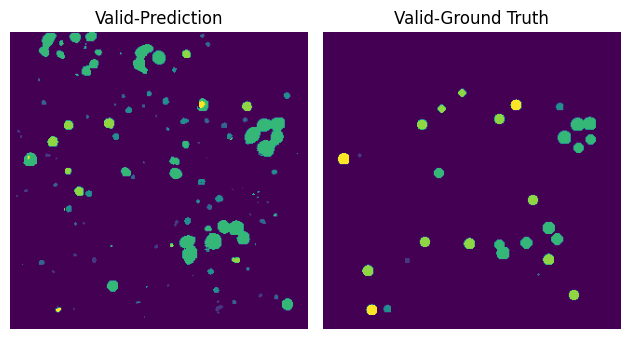

Valid-Epoch: 95, Loss: 0.06598370337061842:  92%|█████████▏| 184/200 [00:08<00:00, 22.52it/s]


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 95, VALID_SCORE: 0.023768724867921136


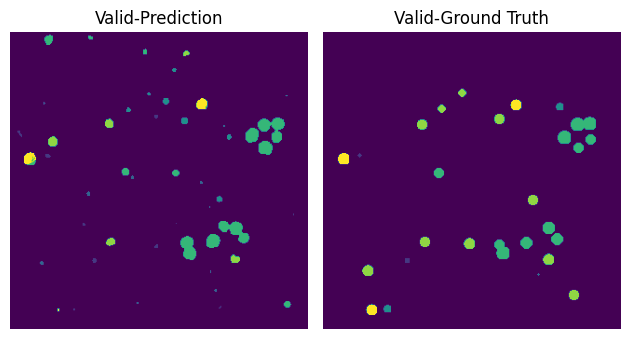

Valid-Epoch: 96, Loss: 0.09392008441941273:  92%|█████████▏| 184/200 [00:08<00:00, 22.41it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 96, VALID_SCORE: 0.042893985692467045


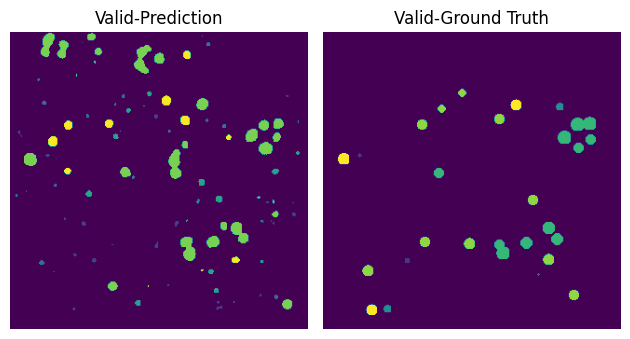

Valid-Epoch: 97, Loss: 0.06835114805880949:  92%|█████████▏| 184/200 [00:08<00:00, 21.36it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 97, VALID_SCORE: 0.0426967728179705


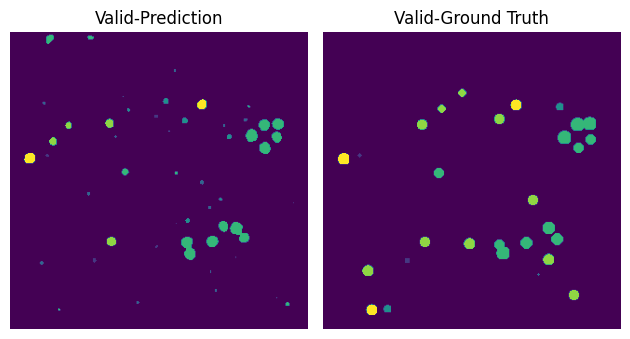

Valid-Epoch: 98, Loss: 0.06918224763924864:  92%|█████████▏| 184/200 [00:08<00:00, 22.01it/s] 


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 98, VALID_SCORE: 0.04361628566496307


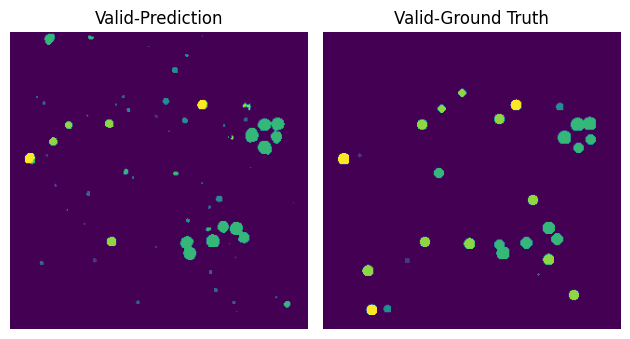

Valid-Epoch: 99, Loss: 0.065436594968283:  92%|█████████▏| 184/200 [00:08<00:00, 21.90it/s]   


####################### valid-experiments: TS_86_3 #######################
####################### valid-experiments: TS_6_6 #######################
EPOCH: 99, VALID_SCORE: 0.030064039576771645


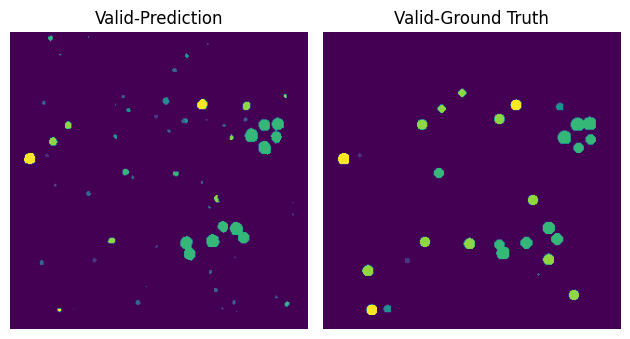

In [4]:
model = UNet_2D().to("cuda")
model.eval()


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(
    # weight=torch.tensor([0.5, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()

best_model = None
best_score = 0
batch_size = 4

for epoch in range(100):
    train_loss = []
    valid_loss = []
    train_pred_tomogram = defaultdict(list)
    train_gt_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)
    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    for data in train_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"]
        segmentation_map = data["segmentation_map"].long()

        for i in range(batch_size, tomogram.shape[1], batch_size):
            optimizer.zero_grad()
            from_, to_ = 0, tomogram.shape[1]
            random_index = random.sample(range(from_, to_), batch_size)
            input_ = tomogram[:, random_index]
            input_ = input_.permute(1, 0, 2, 3)  # (batch_size, 1, 160, 160)
            gt = segmentation_map[:, random_index].squeeze()  # (batch_size, 160, 160)

            input_, gt = aug(input_, gt)

            input_ = input_.to("cuda")
            gt = gt.to("cuda")
            output = model(input_)
            loss = criterion(output, gt)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            for i in range(batch_size):
                train_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
                train_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    ############################################# valid #############################################

    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            output = model(input_)
            loss = criterion(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            valid_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            valid_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    valid_score_ = visualize_epoch_results(
        valid_pred_tomogram,
        valid_gt_tomogram,
        sikii_dict=CFG.initial_sikii,
    )

    print(f"EPOCH: {epoch}, VALID_SCORE: {valid_score_}")

    if valid_score_ > best_score:
        best_score = valid_score_
        best_model = model
        torch.save(model.state_dict(), f"best_model.pth")

    # 可視化
    index = 50

    # plt.figure(figsize=(10, 5))

    # ax = plt.subplot(1, 4, 1)
    # ax.imshow(train_pred_tomogram[exp_name][index].argmax(0))
    # ax.set_title("Train-Prediction")
    # ax.axis("off")

    # ax = plt.subplot(1, 4, 2)
    # ax.imshow(train_gt_tomogram[exp_name][index])
    # ax.set_title("Train-Ground Truth")
    # ax.axis("off")

    ax = plt.subplot(1, 2, 1)
    ax.imshow(valid_pred_tomogram[exp_name][index].argmax(1).squeeze(0))
    ax.set_title("Valid-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 2, 2)
    ax.imshow(valid_gt_tomogram[exp_name][index].squeeze(0))
    ax.set_title("Valid-Ground Truth")
    ax.axis("off")

    plt.tight_layout()

    plt.show()

    # save_images(
    #     train_gt_tomogram=train_gt_tomogram,
    #     train_pred_tomogram=train_pred_tomogram,
    #     valid_gt_tomogram=valid_gt_tomogram,
    #     valid_pred_tomogram=valid_pred_tomogram,
    #     save_dir="images",
    #     epoch=epoch,
    # )

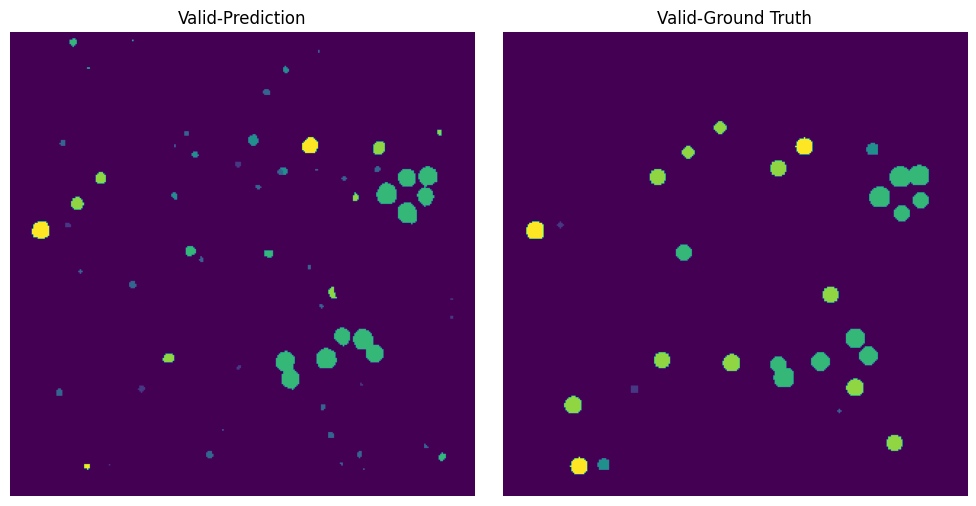

In [5]:
# 可視化
index = 50

plt.figure(figsize=(10, 5))

# ax = plt.subplot(1, 4, 1)
# ax.imshow(train_pred_tomogram[exp_name][index].argmax(0))
# ax.set_title("Train-Prediction")
# ax.axis("off")

# ax = plt.subplot(1, 4, 2)
# ax.imshow(train_gt_tomogram[exp_name][index])
# ax.set_title("Train-Ground Truth")
# ax.axis("off")

ax = plt.subplot(1, 2, 1)
ax.imshow(valid_pred_tomogram[exp_name][index].argmax(1).squeeze(0))
ax.set_title("Valid-Prediction")
ax.axis("off")

ax = plt.subplot(1, 2, 2)
ax.imshow(valid_gt_tomogram[exp_name][index].squeeze(0))
ax.set_title("Valid-Ground Truth")
ax.axis("off")

plt.tight_layout()

plt.show()